<a href="https://colab.research.google.com/github/JingQian87/AppliedDL/blob/master/A2_Part2_jq2282.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 2. Write a model to classify your dataset using transfer learning. Run an experiment and report your results. What do you find?

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Step1. Load and explore data


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
local_zip = '/content/CUlandmarks.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
!ls '/tmp/'
!ls '/tmp/CUlandmarks/train/'

CUlandmarks    drivefs_ipc.0_shell  pymp-_5ksodwi  val
drivefs_ipc.0  LICENSE.txt	    train
Hamilton  LeMarteleur  Lion  Uris


In [26]:
base_dir = '/tmp/CUlandmarks'
import os
try:
  os.remove(os.path.join(base_dir,'.DS_Store'))
except OSError:
  pass
train_dir = os.path.join(base_dir,'train')
try:
  os.remove(os.path.join(train_dir,'.DS_Store'))
except OSError:
  pass
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir,'test')
try:
  os.remove(os.path.join(validation_dir,'.DS_Store'))
except OSError:
  pass
try:
  os.remove(os.path.join(test_dir,'.DS_Store'))
except OSError:
  pass

total_train = 0
for i in os.listdir(train_dir):
  try:
    os.remove(os.path.join(os.path.join(train_dir, i),'.DS_Store'))
  except OSError:
    pass
  tmp = len(os.listdir(os.path.join(train_dir, i)))
  print('Training ', i, ' images:', tmp)
  total_train += tmp
 
total_val = 0
for i in os.listdir(validation_dir):
  try:
    os.remove(os.path.join(os.path.join(validation_dir, i),'.DS_Store'))
  except OSError:
    pass
  tmp = len(os.listdir(os.path.join(validation_dir, i)))
  print('Validation ', i, ' images:', tmp)
  total_val += tmp
 
total_test = 0
for i in os.listdir(test_dir):
  try:
    os.remove(os.path.join(os.path.join(test_dir, i),'.DS_Store'))
  except OSError:
    pass
  tmp = len(os.listdir(os.path.join(test_dir, i)))
  print('Test ', i, ' images:', tmp)
  total_test += tmp
  
print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

Training  LeMarteleur  images: 100
Training  Hamilton  images: 100
Training  Lion  images: 100
Training  Uris  images: 100
Validation  LeMarteleur  images: 50
Validation  Hamilton  images: 50
Validation  Lion  images: 50
Validation  Uris  images: 50
Test  LeMarteleur  images: 25
Test  Hamilton  images: 25
Test  Lion  images: 25
Test  Uris  images: 25
--
Total training images: 400
Total validation images: 200
Total testing images: 100


Use VGG model

<font color='red'>shuffle?!<font>

In [27]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
#conv_base.summary()

TARGET_SHAPE = 150
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 400)
validation_features, validation_labels = extract_features(validation_dir, 200)

Instructions for updating:
Colocations handled automatically by placer.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [28]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 400 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
400/400 [==============================] - 0s 1ms/sample - loss: 0.8209 - acc: 0.7750 - val_loss: 0.0359 - val_acc: 1.0000
Epoch 2/50
400/400 [==============================] - 0s 299us/sample - loss: 0.0207 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 3/50
400/400 [==============================] - 0s 298us/sample - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 4/50
400/400 [==============================] - 0s 332us/sample - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 5/50
400/400 [==============================] - 0s 299us/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 6/50
400/400 [==============================] - 0s 290us/sample - loss: 8.1493e-04 - acc: 1.0000 - val_loss

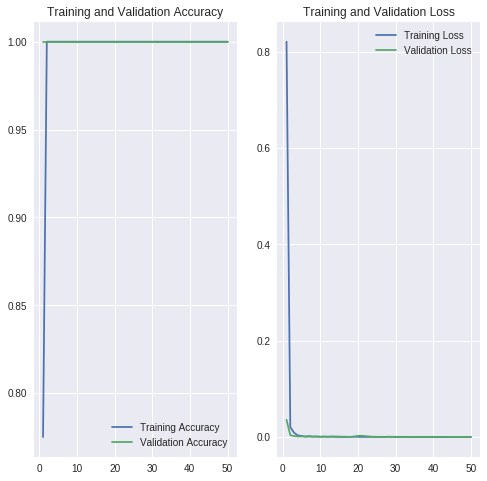

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. how small of a model (in terms of the number of parameters) can you write to classify these images reasonably well? Explore the available pretrained ​models​, and see if any are suitable. Run an experiment and report your results.